In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindFixU #Wind model

avg=0.1 # time that an observation is taken for
tlocL = np.linspace(0,9.9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.1 #Observation noise
N_feat=50 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(np.sqrt(0.6), 1) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0)

#delta,Ns = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

mTest = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0)
regressors = mTest.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mTest.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInferred = mTest.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

Computing Source from Phi...


Calculating Adjoints...
19/20 
Calculating Phis...
49/50 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


In [16]:
regressors.shape

(50, 20)

In [17]:
mTest.coords.shape

(1, 200)

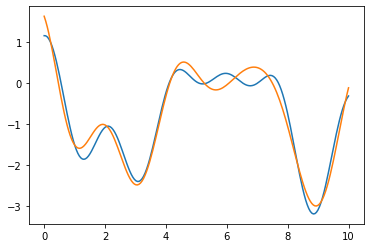

In [18]:
plt.plot(mTest.coords[0,:],sourceInferred)
plt.plot(mTest.coords[0,:],sourceGT)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from advectionGP.models.mesh_adr1d_model import AdjointAdvectionDiffusionReaction1DModel as PDEModel
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindFixU #Wind model

In [2]:
import numpy as np
tlocL = np.linspace(1,8,5) # lower time
xloc=np.linspace(2,8,5) # x locations
sensN = len(xloc)
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,3)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc)).reshape(2,sensN*obsN)[1] # x location
X[:,1] = X[:,0]+1 # upper time
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [3]:
k_0 = 0 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0],[10,10])# corners of the grid - in units of space
k = EQ(5, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0
u=[]
u.append(np.ones(res)*wind) #x direction wind
u.append(np.ones(res)*0.0) # y direction wind
windmodel=WindFixU(u)
#u.append(np.ones(res)*0.1) #x direction wind
#u.append(np.ones(res)*0.1) # y direction wind
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

#dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source



/home/mike/Documents/Research/advectionGP/advectionGP/models/mesh_adr1d_model.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if (delta[1]>=2*self.k_0/np.min(np.abs(self.u))): print("WARNING: spatial grid size does not meet the finite difference advection diffusion stability criteria")
/home/mike/Documents/Research/advectionGP/advectionGP/models/mesh_adr1d_model.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  if (delta[0]>=delta[1]**2/(2*self.k_0)): print("WARNING: temporal grid size does not meet the finite difference advection diffusion stability criteria")


Computing Source from Phi...


In [4]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

In [5]:
N_feat =10 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

Calculating Adjoints...
24/25 
Calculating Phis...
9/10 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


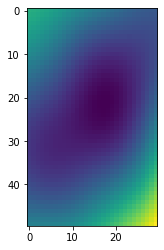

In [11]:
plt.imshow(sourcePDE)

In [1]:
from advectionGP.models.mesh_adr2d_model import AdjointAdvectionDiffusionReaction2DModel as PDEModel
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindFixU #Wind model

In [2]:
import numpy as np
tlocL = np.linspace(1,8,5) # lower time
xloc=np.linspace(2,8,5) # x locations
yloc=np.linspace(2,8,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [3]:
k_0 = 0 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(5, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0
u=[]
u.append(np.ones(res)*wind) #x direction wind
u.append(np.ones(res)*0.0) # y direction wind
windmodel=WindFixU(u)
#u.append(np.ones(res)*0.1) #x direction wind
#u.append(np.ones(res)*0.1) # y direction wind
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

#dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source



/home/mike/Documents/Research/advectionGP/advectionGP/models/mesh_adr2d_model.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if (delta[1]>=2*self.k_0/np.min(np.abs(self.u))): print("WARNING: spatial grid size does not meet the finite difference advection diffusion stability criteria")
/home/mike/Documents/Research/advectionGP/advectionGP/models/mesh_adr2d_model.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  if (delta[0]>=delta[1]**2/(2*self.k_0)): print("WARNING: temporal grid size does not meet the finite difference advection diffusion stability criteria")


Computing Source from Phi...


In [4]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

In [5]:
N_feat =10 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

Calculating Adjoints...
124/125 
Calculating Phis...
9/10 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


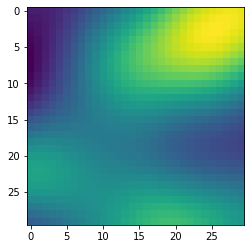

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sourcePDE[15,:,:])
#sourcePDE.shape

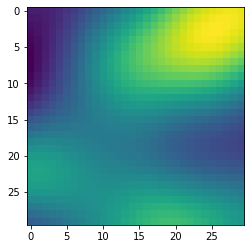

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sourcePDE[15,:,:])
#sourcePDE.shape

In [8]:
obsLocs

NameError: name 'obsLocs' is not defined

In [ ]:
obsLocs